In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from copy import deepcopy
import utils
#from attnUnet import AttentionUNet
from unet import UNet
from unet_parts_t import TemporalEncoding, DoubleConvTime
from scipy.stats import pearsonr
%load_ext autoreload
%autoreload 2
torch.cuda.set_device(0)
from netCDF4 import Dataset

In [2]:
root_dir = "data/"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

For simplcity, only the worst case scenario is considered, i.e. T1-T4 for training and T5 for testing. Each file below is an $ncrcat$ of the three files per simulation in the online database by $Ponte\,et\,al$.

$p_{\theta}(y|x)$

$\theta = \theta*$

$\theta^{n+1} = \theta^{n} + lr*\frac{\partial\,L}{\partial \theta^{n}}$

$\phi{1} = \theta^{n} + lr*\frac{\partial\,L}{\partial \theta^{n}}$

In [4]:
files_train = ['wp50_23.nc', 'wp60_23.nc', 'wp75_23.nc', 'wp80_23.nc']
file_test = 'wp90_23.nc'
nctrains = [Dataset(root_dir + f, 'r') for f in files_train]
nctest = Dataset(root_dir + file_test, 'r')

In [5]:
Xtrain = np.concatenate([nc.variables['ssh_ins'][:,:,:] for nc in nctrains],axis = 0);
Ytrain = np.concatenate([nc.variables['ssh_cos'][:,:,:] for nc in nctrains],axis = 0);
print(Xtrain.shape, Ytrain.shape)

(400, 722, 258) (400, 722, 258)


In [6]:
Xtest = nctest.variables['ssh_ins'][:,:,:]; 
Ytest = nctest.variables['ssh_cos'][:,:,:]; 
Xtest.shape, Ytest.shape

((100, 722, 258), (100, 722, 258))

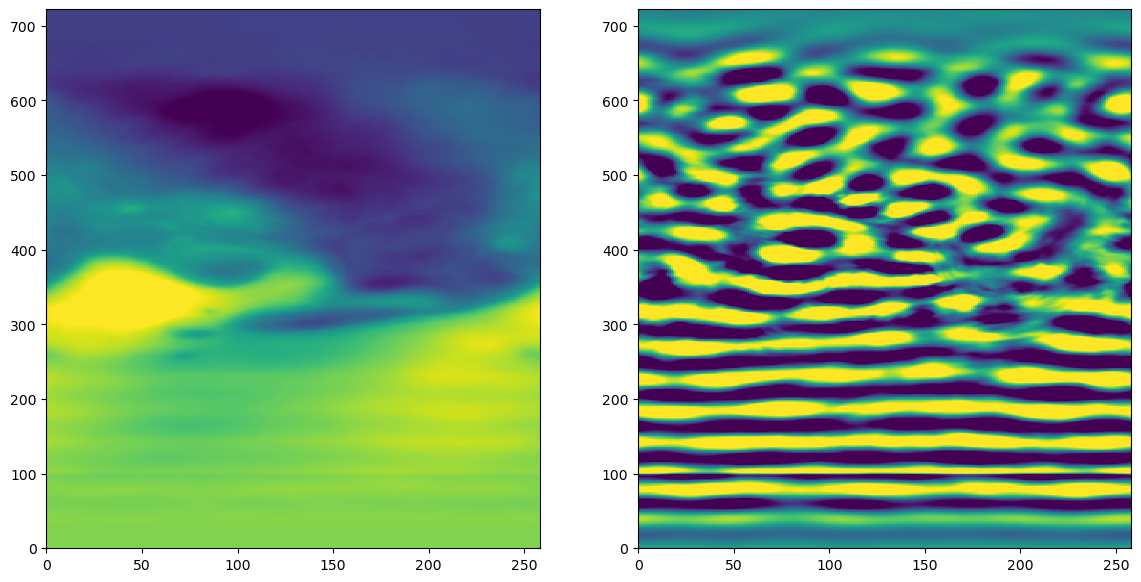

In [7]:
fig,ax = plt.subplots(1,2,figsize = (14,7))
ax[0].pcolormesh(Xtrain.squeeze()[-30,...], vmin = -1, vmax = 1)
ax[1].pcolormesh(Ytrain.squeeze()[-30,...], vmin = -0.01, vmax = 0.01)


In [8]:
vari = 'ssh_ins'
Ntrain = np.sum([nc.dimensions['time_counter'].size for nc in nctrains], axis = 0); print('number of training records:', Ntrain)
numTrainFiles = len(nctrains)
numRecsFile = nctrains[0].dimensions['time_counter'].size; numRecsFile

number of training records: 400


100

In [9]:
a = np.arange(720)
yslice = a[360-128:360+128]; yslice.shape

(256,)

In [10]:

def normalize(x, mean=None, std=None):
    if mean is None:
        mean = np.mean(x.squeeze(), axis = (0, 1, 2))
        std = np.std(x.squeeze(), axis = (0, 1, 2)) 
        #return (x.squeeze()-mean[None, :, None])/std[None,:, None], mean, std
        return (x.squeeze()-mean)/std, mean, std
    
    else:
        #return (x-mean[None, :, None])/std[None, :, None]
        return (x.squeeze()-mean)/std
    
xmtrain, meanx, stdx =  normalize(Xtrain)
ymtrain, meany, stdy =  normalize(Ytrain)
print(meanx.shape, stdx.shape)
#xmtest, meanxt, stdxt =  normalize(Xtest, meanx, stdx)
#ymtest, meanyt, stdyt =  normalize(Ytest, meany, stdy)
xmtest =  normalize(Xtest, meanx, stdx)
ymtest =  normalize(Ytest, meany, stdy)

# xmtest =  normalize(Xtest, meanx, stdx)
# ymtest =  normalize(Ytest, meany, stdy)

print(xmtrain.shape, xmtest.shape)
Ntrain  = xmtrain.shape[0]
Ntest  = xmtest.shape[0]


() ()
(400, 722, 258) (100, 722, 258)


In [11]:
#BCHW input with C=1
def loadtrain(index, batch_size):
    return xmtrain[index:index+batch_size,None, :, :256], ymtrain[index:index+batch_size,None, :, :256] 

# def loadtest(index, batch_size):
#     return ymtest[index:index+batch_size, :, :256], ymtest[index:index+batch_size, :, :256] 
def loadtest():
     return xmtest[:,None, :, :256], ymtest[:,None, :, :256]
    
x, y = loadtrain(0,50)
print(x.shape, y.shape)

(50, 1, 722, 256) (50, 1, 722, 256)


In [12]:

def totorch(x):
    return torch.tensor(x, dtype = torch.float).cuda()
def tonumpy(x):
    return x.detach().cpu().numpy()
Nbase = 16

In [13]:
#inp, out_test = loadtest()
inp, out_test = xmtest[:,None,:,:], ymtest[:,None,:,:] 
with torch.no_grad():
    inp_test = totorch(inp)
    #out_model = attention_unet(inp_test)

In [14]:
Ntest = inp.shape[0]

(100, 722, 258)


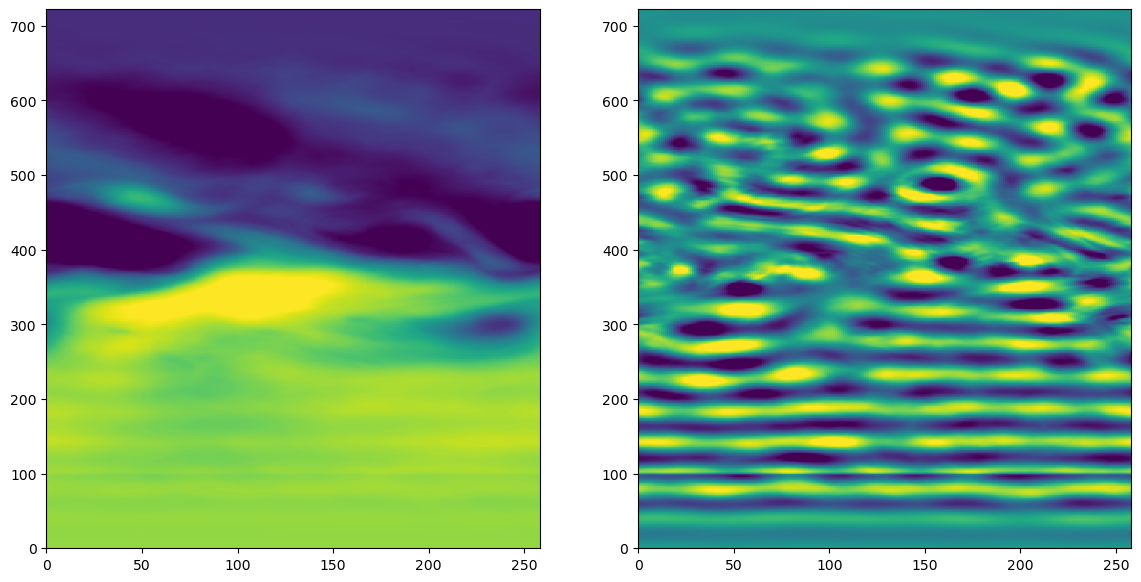

In [15]:
print(xmtest.shape)
fig,ax = plt.subplots(1,2,figsize = (14,7))
ax[0].pcolormesh(xmtest.squeeze()[30,:,:], vmin = -2, vmax = 2)
ax[1].pcolormesh(ymtest.squeeze()[30,:, :], vmin = -2, vmax = 2)
#ax[0].pcolormesh(xmtrain.squeeze()[-30,:,:], vmin = -2, vmax = 2)
#ax[1].pcolormesh(ymtrain.squeeze()[-30,:, :], vmin = -2, vmax = 2)


In [16]:

Nsteps = 20
#alphas is our fake time
alphas = np.linspace(0,1,Nsteps)
print(alphas)
def interp(inp, out, step, alphas = alphas):
    #print(alphas.shape, step, inp.shape, out.shape)
    return inp * (1-alphas[step]) + out * (alphas[step]),\
           inp * (1-alphas[step+1]) + out * (alphas[step+1]),\
           alphas[step]
print(inp.shape, out_test.shape)


[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
(100, 1, 722, 258) (100, 1, 722, 258)


Nint: 78


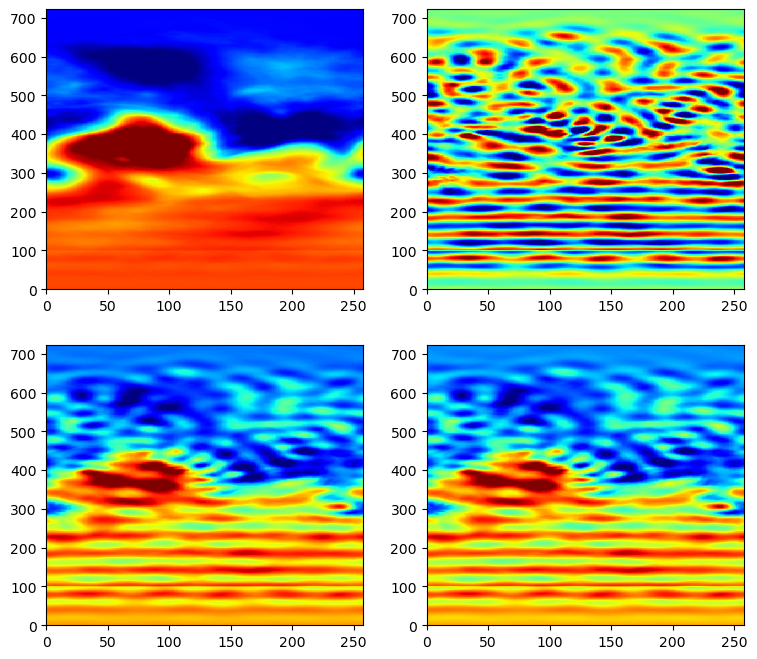

In [17]:
#Nint = np.random.randint(0,Nsteps); print(f'Nint: {Nint}')
Nstep_int = 6 
inter_step, inter_step1, time_step = interp(inp.squeeze(), out_test.squeeze(), Nstep_int)
fig, axs = plt.subplots(2,2, figsize = (9,8))

Nint = np.random.randint(Ntest) 
print(f'Nint: {Nint}')
inp0, out0, interp0, interp1 = inp.squeeze()[Nint,:,:],\
                               out_test.squeeze()[Nint,:,:],\
                               inter_step.squeeze()[Nint,:,:],\
                               inter_step1.squeeze()[Nint,:,:] 
cmap = 'jet'
lims = [-2, 2]
ax = axs.ravel()
ax[0].pcolormesh(inp0, cmap = cmap, vmin = lims[0], vmax = lims[1])
ax[1].pcolormesh(out0, cmap = cmap, vmin = lims[0], vmax = lims[1])
ax[2].pcolormesh(interp0, cmap = cmap, vmin = lims[0], vmax = lims[1])
ax[3].pcolormesh(interp1, cmap = cmap, vmin = lims[0], vmax = lims[1])

A simple UNet model that is much smaller than the standard UNet. The Nbase argument sets how many filters are present in the first down layer. The standard UNet has 64 in the first layer, rising to 1024 filters in the final encoder layer. This one below starts at 16, ends at 256. Might be worth exploring if other more sophisticated UNets do better. Attention UNet (circa 2020) was poor but more modern Swin-based architectures or UNet3+ (though some mods are required here before application) might be worth a test.

Finally, an input batchnorm layer is added which avoids worrying about normalizing the data. This can be dangerous but probably not for this problem.

In [18]:
inp_test.shape, inp_test.size(), Ntrain
xtest, ytest = loadtest()
xtest, ytest = totorch(xtest), totorch(ytest)
print(xtest.shape, ytest.shape)

torch.Size([100, 1, 722, 256]) torch.Size([100, 1, 722, 256])


In [19]:
#model = AttentionUNet(Nbase = 16).to(device)
sin = False
if sin:
    no = 2
else:
    no = 1
#time has to be [B,1]
Nemb = 100
input = torch.randn(1,1,256,256).cuda()
time = totorch(np.linspace(0,1,40)).reshape(1,40)
Tindex = 10
tinp = torch.unsqueeze(time[:,Tindex], 0)
print(time.shape, time[:,0].shape, torch.unsqueeze(time[:,0], 0).shape)

# temp = TemporalEncoding(n_emb = Nemb).cuda()
# tempEnc = temp(tinp)
# print(tempEnc, tempEnc.shape, len(tempEnc))
# dbct = DoubleConvTime(1, 32, n_emb = Nemb).cuda()
# out = dbct(input, tempEnc)
# print(out.shape)

model = UNet(1, no, bilinear = True, Nbase = 16, n_emb = 100).cuda()
output = model(input, torch.unsqueeze(time[:,0], 0)) 
print('Model has ', utils.nparams(model)/1e6, ' million params')

torch.Size([1, 40]) torch.Size([1]) torch.Size([1, 1])
Model has  1.148133  million params


The choice of L1Loss here works better than MSEloss likely due to a large number of outliers. 

There are two non-standard choices here. First cyclical annealing with a fixed and relatively short Tcycle which I find works better than other choices (including the linearly increasing scheme in the original SGDR paper). This approach is also homogenous in time and ideal for interrupting training and re-training. 

Second the best model that has the maximum coeffecient of restitution $R^2$ is kept in memory. This ensures that overfitting is always avoided by design. 

Permuting the data order did not really improve matters (set the perm flag to True).

Also note that no test loss is computed, instead using $R^2$ directly for model selection.

Note that the pytorch scheduler has SGDR (Loschilov & Hutter 2017) implemented though it is slightly more annoying to use, so I use my own variant.

In [25]:
def test_step(model, xtest, ytest, time):
    Ninterp = max(time.shape)
    assert(Ninterp>0)
    time_step = np.random.randint(0, Ninterp-1)
    t = torch.unsqueeze(time[:,time_step], 0)
    inter_step, inter_step1, time_step = interp(xtest, ytest, time_step, alphas = time.T)
    y_mod = model(inter_step, t)
    
    r2 = R2(inter_step1.cpu().numpy().flatten(), (y_mod).cpu().numpy().flatten())
    return r2
#autoregressive test through the inp-out flow
def test_stepAR(model, xtest, ytest, time):
    Ninterp = max(time.shape)
    assert(Ninterp>0)
    #time_step = np.random.randint(0, Ninterp-1)
    #inter_step, inter_step1, time_step = interp(xtest, ytest, time_step, alphas = time.T)
    x0 = xtest    
    for time_step in range(Ninterp - 1): 
        t = torch.unsqueeze(time[:,time_step], 0)
        x1 = model(x0, t)
        x0 = x1
    
    r2 = R2(ytest.cpu().numpy().flatten(), x1.cpu().numpy().flatten())
    return r2


In [28]:
batch_size = 50
Ninterp = 2
#lr0=0.01
lr0 = 0.005
maxEpochs = 50
Tcycle = 10
criterion_train  = nn.L1Loss()
criterion_test = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr=lr0, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

In [29]:
out_test = torch.tensor(out_test).cuda()


/tmp/ipykernel_85430/1019209728.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_test = torch.tensor(out_test).cuda()


In [31]:
#lr0 = 0.005
# loss_train = np.zeros(maxEpochs)
time = totorch(np.linspace(0,1,Ninterp)).reshape(1,Ninterp)
print(f'time: {time.min()} to {time.max()},\n {time.shape}')
r2_test = np.zeros(maxEpochs)
epochmin = []
maxr2l = []

learn = np.zeros(maxEpochs)
minloss = 1000
maxR2 = -1000
minlosscount = 0
perm = False
eps_min, eps_max = 1e-8, 0.2
leps_low, leps_high = np.log10(eps_min), np.log10(eps_max)

print('Starting training loop')
low, high = 0, 1

for epoch in tqdm(range(maxEpochs)):
    leps_mag = leps_low + (leps_high - leps_low) * (epoch)/maxEpochs
    eps_mag = 10**leps_mag
    lr = utils.cosineSGDR(optim, epoch, T0=Tcycle, eta_min=0, eta_max=lr0, scheme = 'constant')  
    model.train()
    index_perm = np.arange(0, Ntrain, batch_size)
    if perm:
        index_perm = np.random.permutation(index_perm)
    for index in index_perm:
        x, y = loadtrain(index, batch_size)
        x, y = totorch(x), totorch(y)
        time_step = np.random.randint(0, Ninterp-1)
        #t is the fake time between 0 and 1 and is an input to the model
        t = torch.unsqueeze(time[:,time_step], 0)
        inter_step, inter_step1, time_step = interp(x, y, time_step, alphas = time.T)

        y_mod = model(inter_step, t)
        loss = criterion_train(inter_step1.squeeze(), y_mod.squeeze())
        #Set gradient to zero
        optim.zero_grad()
        #Compute gradients       
        loss.backward()
        #Update parameters with new gradient
        optim.step()
        #Record train loss
        #scheduler.step()
    model.eval()
    with torch.no_grad():
        r2 = test_stepAR(model, xtest, ytest, time)
        r2_test[epoch] = r2
        #record current best model and best predictions
        if maxR2 <  r2:
            maxR2 = r2
            epochmin.append(epoch)
            maxr2l.append(maxR2)                
            model_best = deepcopy(model)
            print('eps:', eps_mag, 'R2:', r2)
            #corr, pval = pearsonr(out_test.flatten(), (out_mod).cpu().numpy().flatten())
            #print('eps:', eps_mag, 'R2:', r2, ' corr: ', corr, ' pval: ', pval)

time: 0.0 to 1.0,
 torch.Size([1, 2])
Starting training loop


  2%|█▉                                                                                             | 1/50 [00:04<03:32,  4.34s/it]

eps: 1e-08 R2: 0.6253203325890232


  8%|███████▌                                                                                       | 4/50 [00:17<03:17,  4.29s/it]

eps: 2.741964323387269e-08 R2: 0.6358287063067625


 12%|███████████▍                                                                                   | 6/50 [00:25<03:08,  4.29s/it]

eps: 5.371591767636877e-08 R2: 0.6448790985204572


 20%|██████████████████▊                                                                           | 10/50 [00:43<02:52,  4.31s/it]

eps: 2.061509778778177e-07 R2: 0.6476239622296333


 32%|██████████████████████████████                                                                | 16/50 [01:08<02:26,  4.32s/it]

eps: 1.5499189875483373e-06 R2: 0.6480877077800038


 38%|███████████████████████████████████▋                                                          | 19/50 [01:21<02:13,  4.32s/it]

eps: 4.249822567998057e-06 R2: 0.6515490593308735


 40%|█████████████████████████████████████▌                                                        | 20/50 [01:26<02:09,  4.32s/it]

eps: 5.9482799277401535e-06 R2: 0.6535514656549197


 54%|██████████████████████████████████████████████████▊                                           | 27/50 [01:56<01:39,  4.33s/it]

eps: 6.25944168482783e-05 R2: 0.6568086963289366


 58%|██████████████████████████████████████████████████████▌                                       | 29/50 [02:05<01:30,  4.33s/it]

eps: 0.000122624372379463 R2: 0.6578183732379942


 60%|████████████████████████████████████████████████████████▍                                     | 30/50 [02:09<01:26,  4.33s/it]

eps: 0.00017163165784120973 R2: 0.6605487988929601


 78%|█████████████████████████████████████████████████████████████████████████▎                    | 39/50 [02:48<00:47,  4.31s/it]

eps: 0.003538203409875648 R2: 0.6643223663251431


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 40/50 [02:52<00:43,  4.31s/it]

eps: 0.004952259532364257 R2: 0.6651108082992074


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:35<00:00,  4.31s/it]

eps: 0.14289248722740003 R2: 0.6651234873182204


In [23]:
eps_mag

0.14289248722740003

In [24]:
inp_data = tonumpy(inp_test.squeeze())
out_data = tonumpy(out_mod.squeeze()) 
inp_noise_data = tonumpy(inp_test_noise.squeeze()) 


Nint: 38


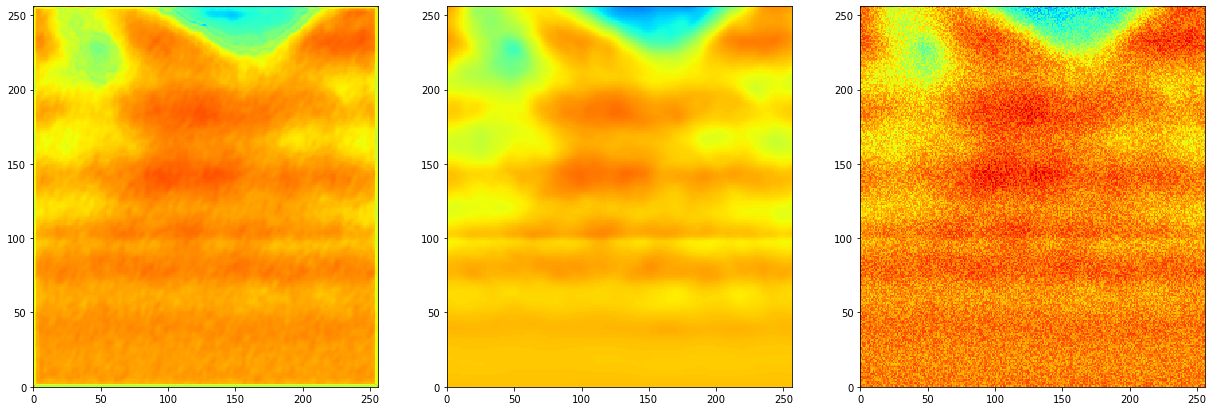

In [25]:
fig, ax = plt.subplots(1,3, figsize = (21,7))
Nint = np.random.randint(50); print(f'Nint: {Nint}')
cmap = 'jet'
lims = [0, 1]
ax[0].pcolormesh(out_data[Nint,:,:], cmap = cmap, vmin = lims[0], vmax = lims[1])
ax[1].pcolormesh(inp_data[Nint,:,:], cmap = cmap, vmin = lims[0], vmax = lims[1])
ax[2].pcolormesh(inp_noise_data[Nint,:,:], cmap = cmap, vmin = lims[0], vmax = lims[1])

In [29]:
np.mean(out_data -inp_data)

0.037401613

The best-$R^2$ enevelope (in red below) is a monotonicaly increasing curve and the model corresponding to the right-most point on this curve is the best model across the whole process of training w.r.t the test set. Around epoch 250, the curve stops increasing, indicating that there might be not much gains to be had (counterpoint, the grokking paper) though longer training to around 1000 epochs might be worth a try. 

Interestingly the UNet with MaxPool does not have these huge accuracy drawdowns seen in the black curve below. But the MixPool version reaches an overall lower loss. It is evident that the training dynamics here is uncharacteristically complex. 

Given the large drawdowns, we see above that the large three best-models are close to 79.8 correlation and can be concievably ensembled to see if this improves performance.

Text(0, 0.5, '$R^2$')

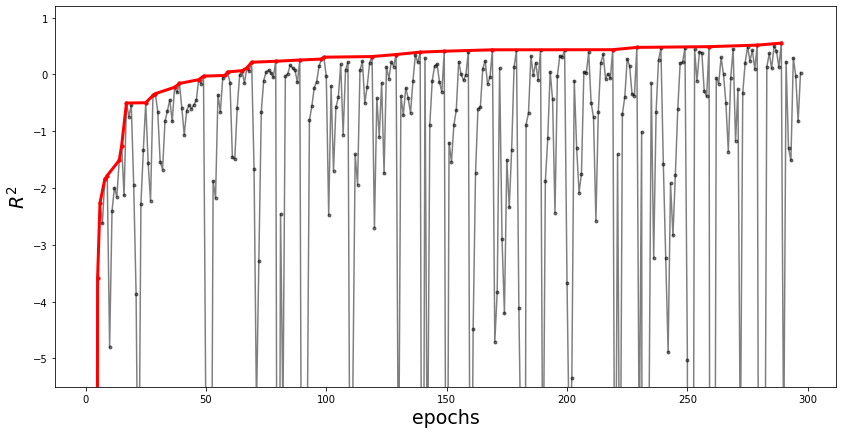

In [24]:
fig = plt.figure(figsize = (14,7))
mE  = 298
plt.plot(np.arange(2,mE), r2_test[2:mE], 'k.-', alpha = 0.5)
plt.plot(np.array(epochmin[1:]), np.array(maxr2l[1:]), 'r.-', linewidth = 3)
plt.ylim([-5.5, 1.2])
plt.xlabel('epochs', fontsize = 19)
plt.ylabel('$R^2$', fontsize = 19)

We can focus just on the final 100 epochs to see the $R^2$ drawdowns

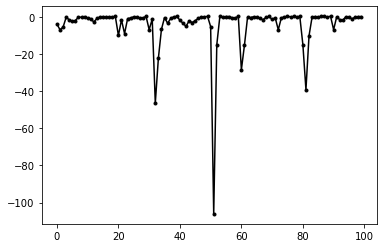

In [25]:
plt.plot(np.array(r2_test)[-100:], 'k.-')

In [26]:
_, out_test = loadtest()
model_best.eval()
with torch.no_grad():
  #inp_test = totorch(inp)
   out_mod = model_best(inp_test).detach().cpu().numpy()
    
    
    
#****This is if you want to interrupt training and retrain. No need to initialize the optimizer here
model = deepcopy(model_best)

In [27]:
Nx, Ny = out_test.shape[2:]; Nx, Ny

(720, 256)


Test performance on a random snapshot which changes on each refresh. Here the reported $R^2$ and correlations are of a subregion (278, 600) which is where most of the action seems to be happening. 

Nind: 99
R2: 0.18829695841554905
corr: 0.4856855323045826


Text(0.5, 1.0, '$\\eta^{\\theta}_{cos}$ vs $\\eta^{D}_{cos}$')

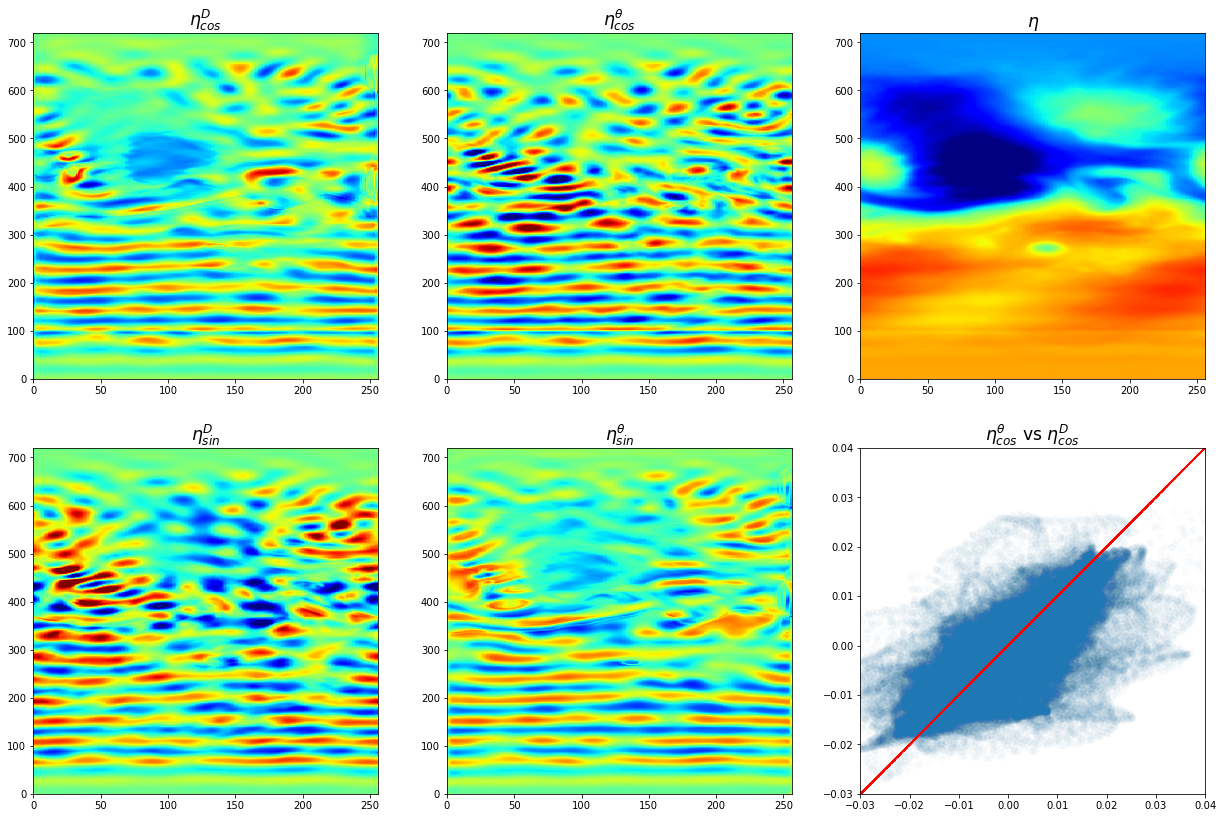

In [30]:
plt.rcParams.update({'axes.titlesize': 'xx-large'})
fig, axs = plt.subplots(2, 3, figsize = (21,14))
Nind = np.random.randint(100); print (f'Nind: {Nind}')
ax = axs.ravel()
vlim = 0.03
cmap = 'jet'
inds = slice(278, 600)
print('R2:', R2(out_test[Nind, :,inds, :].flatten(), out_mod[Nind, :, inds, :].flatten()))

print('corr:', pearsonr(out_test[Nind, :,inds, :].flatten(), out_mod[Nind, :, inds, :].flatten())[0])

ssh_cos_mod,  ssh_cos_data = out_mod[Nind, 0, :, :], out_test[Nind, 0, :, :]
ssh_sin_mod,  ssh_sin_data = out_mod[Nind, 1, :, :], out_test[Nind, 1, :, :]
ssh = inp_test[Nind, 0, :, :]

ax[0].pcolormesh(ssh_cos_mod, vmin = -vlim, vmax = vlim, cmap = cmap)
ax[0].set_title(r'$\eta^D_{cos}$')

ax[1].pcolormesh(ssh_cos_data, vmin = -vlim, vmax = vlim, cmap = cmap)
ax[1].set_title(r'$\eta^{\theta}_{cos}$')

ax[2].pcolormesh(ssh.cpu().numpy(), vmin = -1.5, vmax = 1.5, cmap = cmap)
ax[2].set_title(r'$\eta$')

ax[3].pcolormesh(ssh_sin_data, vmin = -vlim, vmax = vlim, cmap = cmap)
ax[3].set_title(r'$\eta^D_{sin}$')

ax[4].pcolormesh(ssh_sin_mod, vmin = -vlim, vmax = vlim, cmap = cmap)
ax[4].set_title(r'$\eta^{\theta}_{sin}$')

ax[5].scatter(ssh_cos_data.flatten(), ssh_cos_mod.flatten(), alpha = 0.02)
ax[5].set_xlim([-0.03, 0.04])
ax[5].set_ylim([-0.03, 0.04])
ax[5].plot(out_test[Nind, 0, inds, :].flatten(), out_test[Nind, 0, inds, :].flatten(), 'r--')
ax[5].set_title(r'$\eta^{\theta}_{cos}$ vs $\eta^{D}_{cos}$')
#ax[5].pcolormesh(inp_test[Nind, 0, :, :].cpu().numpy(), vmin = -1, vmax = 1, cmap = cmap)


Checkpoint the best model. Can resume training from here if necessary

In [23]:
#print(len(model_list))
import os
dr = './models'
try:
    os.mkdir(dr)
except:
    print('Directory exists or disk full...')
fstr = f'mixpool_23_{Nbase}_{lr0}_{batch_size}'
PATH = dr + f'/Unet_{fstr}.pth'
torch.save(model_best.state_dict(), PATH)


Directory exists or disk full...


Write I/O data into file for comparison

In [61]:
outdr = './data/'
nco = utils.ncCreate(outdr + f'output_{fstr}.nc', Nx, Ny, ['sin_model', 'cos_model', 'sin_data', 'cos_data'])
utils.addVal(nco, 'cos_model', out_mod[:, 0, :, :])
utils.addVal(nco, 'sin_model', out_mod[:, 1, :, :])
utils.addVal(nco, 'cos_data', out_test[:, 0, :, :])
utils.addVal(nco, 'sin_data', out_test[:, 1, :, :])
nco.close()

